# Rumor Detection using the PHEME dataset

Instruction to run:
1. Install Contractions, XGBoost, TensorFlow, Keras, Scikit-learn, Matplotlib, Seaborn, Plotly, NLTK libraries
2. Download dataset https://www.kaggle.com/datasets/manuelcecerepalazzo/pheme-dataset/data
3. Navigate to your dataset directory all-rnr-annotated-threads_1

## Installation and Imports

In [ ]:
# !pip install contractions
# %cd /Users/keerthanavelilani
# os.environ['PATH'] += ':/opt/homebrew/bin'
# !brew install libomp
# !pip install xgboost

In [ ]:
# General
import os
import json
import re
import numpy as np
import pandas as pd
from tqdm import tqdm

# TensorFlow and Keras
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K

# Scikit-learn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.preprocessing import label_binarize

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# NLP
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer, PorterStemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# XGBoost
import xgboost as xgb

# Other
import contractions

%matplotlib inline

In [70]:
np.__version__

'1.23.5'

In [71]:
tf.__version__

'2.12.0'

In [75]:
# seed initialization
seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)

## Loading Dataset

In [76]:
# Dataset directory
%cd /Users/keerthanavelilani/Desktop/NEU/Summer2024/NLP/Project/all-rnr-annotated-threads_1

/Users/keerthanavelilani/Desktop/NEU/Summer2024/NLP/Project/all-rnr-annotated-threads_1


In [77]:
# Set the folders to iterate on
folds= ['charliehebdo-all-rnr-threads','ottawashooting-all-rnr-threads',
'ebola-essien-all-rnr-threads','prince-toronto-all-rnr-threads',
'ferguson-all-rnr-threads',	'putinmissing-all-rnr-threads',
'germanwings-crash-all-rnr-threads',
'gurlitt-all-rnr-threads','sydneysiege-all-rnr-threads']

# Initialize lists to store candidate features from the dataset
texts = []
fav_counts = []
retweet_counts = []
date = []

username = []
account_date = []
protected = []
verified = []
followers = []
followings = []
tweets_count = []

hashtag = []
url = []

events = []
y = []

In [78]:
# Convert annotation data to labels
def convert_annotations_data(annotation, string = True):
    if 'misinformation' in annotation.keys() and 'true'in annotation.keys():
        if int(annotation['misinformation'])==0 and int(annotation['true'])==0:
            if string:
                label = "unverified"
            else:
                label = 2
        elif int(annotation['misinformation'])==0 and int(annotation['true'])==1 :
            if string:
                label = "true"
            else:
                label = 1
        elif int(annotation['misinformation'])==1 and int(annotation['true'])==0 :
            if string:
                label = "false"
            else:
                label = 0
        elif int(annotation['misinformation'])==1 and int(annotation['true'])==1:
            print ("They both are 1!")
            print(annotation['misinformation'])
            print(annotation['true'])
            label = None
            
    elif 'misinformation' in annotation.keys() and 'true' not in annotation.keys():
        # all instances have misinfo label but don't have true label
        if int(annotation['misinformation'])==0:
            if string:
                label = "unverified"
            else:
                label = 2
        elif int(annotation['misinformation'])==1:
            if string:
                label = "false"
            else:
                label = 0
                
    elif 'true' in annotation.keys() and 'misinformation' not in annotation.keys():
        print ('Has true not misinformation')
        label = None
    else:
        print('No annotations')
        label = None
           
    return label

In [79]:
# Iterate over folders to load and process the dataset
for f in folds:
    path1 = os.path.join(f, 'rumours')
    for dir1 in os.listdir(path1):
        if '_' not in dir1:
            path_target  = os.path.join(path1,dir1,'annotation.json')
            file = open(path_target)
            data = json.load(file)
            target = convert_annotations_data(data)
            y.append(target)
            path2 = os.path.join(path1, dir1,'source-tweets')
            for dir2 in os.listdir(path2):
                if '_' not in dir2:
                    path3  = os.path.join(path2,dir2)
                    file = open(path3)
                    data = json.load(file)

                    #tweet features
                    text = data['text']
                    tweet_date = data['created_at']
                    fav = data['favorite_count']
                    retw = data['retweet_count']

                    #user features
                    usernames = data['user']['screen_name']
                    account_creation = data['user']['created_at']
                    is_protected = data['user']['protected']
                    is_verified = data['user']['verified']
                    no_followers = data['user']['followers_count']
                    no_followings = data['user']['friends_count']
                    no_tweets = data['user']['statuses_count']

                    #entities
                    no_hashtags = len(data['entities']['hashtags'])      
                    has_url = data['entities']['urls']  
                    text = data['text']
                    fav = data['favorite_count']
                    retw = data['retweet_count']

                    texts.append(text)
                    date.append(tweet_date)
                    fav_counts.append(fav)
                    retweet_counts.append(retw)

                    username.append(usernames)
                    account_date.append(account_creation)
                    protected.append(is_protected)
                    verified.append(is_verified)
                    followers.append(no_followers)
                    followings.append(no_followings)
                    tweets_count.append(no_tweets)


                    hashtag.append(no_hashtags)
                    url.append(has_url)

                    events.append(f)

In [80]:
# Create a DataFrame from the collected data
df = pd.DataFrame([texts,date,fav_counts,retweet_counts,username,account_date,followers,followings,tweets_count,protected,verified,hashtag,url,events,y],['text','date','fav_count','retweet_count','username','account_date','followers','followings','tweet_count','protected','verified','no_hashtags','urls','event','target']).transpose()
df = df.infer_objects()
df.head()

# # Drop categorical data and features with zero variance
df.drop(["date","username","account_date","urls","protected"], axis=1, inplace=True)

# Convert boolean feature 'verified' to numerical
df = df.astype({"verified":'int64'})
df.dtypes

text             object
fav_count         int64
retweet_count     int64
followers         int64
followings        int64
tweet_count       int64
verified          int64
no_hashtags       int64
event            object
target           object
dtype: object

In [27]:
df.head()

,text,fav_count,retweet_count,followers,followings,tweet_count,verified,no_hashtags,event,target
0,BREAKING: Armed man takes hostage in kosher gr...,14,177,193798,614,63575,1,0,charliehebdo-all-rnr-threads,unverified
1,"#CharlieHebdo killers dead, confirmed by genda...",30,134,4709,375,1076,0,1,charliehebdo-all-rnr-threads,true
2,"Top French cartoonists Charb, Cabu, Wolinski, ...",23,148,20401,592,7182,0,2,charliehebdo-all-rnr-threads,unverified
3,Police have surrounded the area where the #Cha...,329,684,15405096,1038,54427,1,1,charliehebdo-all-rnr-threads,true
4,PHOTO: Armed gunmen face police officers near ...,27,113,842236,460,104998,1,1,charliehebdo-all-rnr-threads,true


In [133]:
# Filter the DataFrame by the column value
filtered_df_false = df[df['target'] == 'false']
filtered_df_true = df[df['target'] == 'true']
filtered_df_unverified = df[df['target'] == 'unverified']

# Get the number of rows in the filtered DataFrame
num_rows_false = filtered_df_false.shape[0]
num_rows_true = filtered_df_true.shape[0]
num_rows_unverified = filtered_df_unverified.shape[0]

print('Rumors:',num_rows_false)
print('Non Rumors:',num_rows_true)
print('Unverified:',num_rows_unverified)

Rumors: 638
Non Rumors: 1067
Unverified: 697


## Text cleaning and preparation

In [29]:
# Functions to clean text data
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_characters(text):
    return re.sub('[^a-zA-Z]', ' ', text)

def remove_url(text):
    return re.sub(r'http\S+', '', text)

def remove_contractions(text):
    return ' '.join([contractions.fix(word) for word in text.split()])

def remove_stopwords(text):
    return ' '.join([word for word in nltk.word_tokenize(text) if word not in stop_words])

def lemmatize_words(text):
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split())

def stemming_words(text):
    return ' '.join(stemmer.stem(word) for word in text.split())

def clean_text(text):
    text = remove_url(text)
    text = remove_contractions(text)
    text = text.lower()
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords(text)
    return text

In [ ]:
# Apply text cleaning functions to the 'text' column
df['text'] = df['text'].apply(clean_text)

In [30]:
df.head()

,text,fav_count,retweet_count,followers,followings,tweet_count,verified,no_hashtags,event,target
0,breaking armed man takes hostage kosher grocer...,14,177,193798,614,63575,1,0,charliehebdo-all-rnr-threads,unverified
1,charliehebdo killers dead confirmed gendarmerie,30,134,4709,375,1076,0,1,charliehebdo-all-rnr-threads,true
2,top french cartoonists charb cabu wolinski tig...,23,148,20401,592,7182,0,2,charliehebdo-all-rnr-threads,unverified
3,police surrounded area charliehebdo attack sus...,329,684,15405096,1038,54427,1,1,charliehebdo-all-rnr-threads,true
4,photo armed gunmen face police officers near c...,27,113,842236,460,104998,1,1,charliehebdo-all-rnr-threads,true


## Modeling

## Logistic Regression

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.28      0.41       534
           1       0.27      0.75      0.40       187

    accuracy                           0.40       721
   macro avg       0.52      0.52      0.40       721
weighted avg       0.64      0.40      0.41       721

Logistic Regression Accuracy Score:
0.40499306518723993


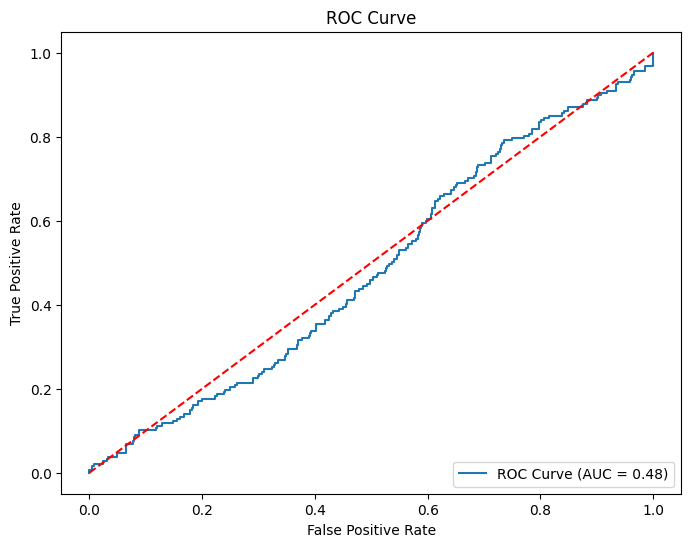

In [123]:
# Prepare the dataset
X_text = df['text']
X_numerical = df.drop(columns=['target', 'event', 'text'])
y = df['target']

# Vectorize the text data
tfidf = TfidfVectorizer(max_features=5000)
X_text_tfidf = tfidf.fit_transform(X_text).toarray()

# Combine text and numerical features
X_combined = np.hstack((X_numerical, X_text_tfidf))

# Convert the target to numerical labels if needed
y = y.map({'false': 1, 'true': 0, 'unverified': 0}) 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

# Set the weights manually (for example: increase weight for class 1)
class_weights = {0: 1, 1: 4}  # Increase weight for the minority class

# Train a Logistic Regression model with custom class weights
logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight=class_weights)
logreg.fit(X_train, y_train)

# Predict and evaluate
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))
print("Logistic Regression Accuracy Score:")
print(accuracy_score(y_test, y_pred))


# Compute ROC curve and ROC area for the model
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#### **The model achieved a low accuracy of approximately 40%, struggling to balance precision and recall, particularly for false rumors, indicating difficulty in effectively distinguishing between true and false information. The AUC indicated the model's limited ability to distinguish between true and false rumors. The ROC curve is close to the diagonal, reflecting the model's struggle to separate the classes effectively, leading to its lower overall accuracy.**

## Random Forest

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.85       534
           1       0.58      0.33      0.42       187

    accuracy                           0.77       721
   macro avg       0.69      0.62      0.64       721
weighted avg       0.74      0.77      0.74       721

Random Forest Accuracy Score:
0.7656033287101248


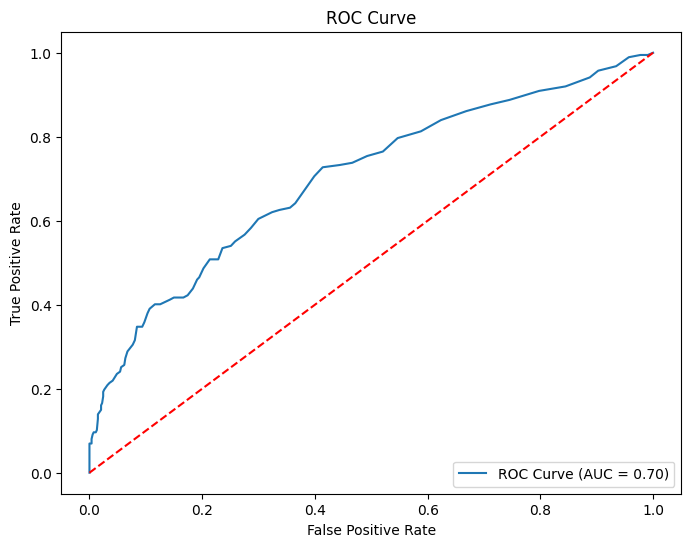

In [92]:
# Separate features and target
X = df.drop(['target', 'event', 'text'], axis=1)  # Dropping non-numerical and non-relevant columns
y = df['target'].map({'false': 1, 'true': 0, 'unverified': 0})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a model with class weights
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))
print("Random Forest Accuracy Score:")
print(accuracy_score(y_test, y_pred))

# ROC Curve and AUC
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

**This model performed better with an accuracy of around 77%, showing a decent balance between precision and recall, especially for true rumors. However, it struggled with lower recall for false rumors. It has a higher AUC, showing that it could better differentiate between the classes. The ROC curve was further from the diagonal, particularly for true rumors, indicating stronger classification performance compared to Logistic Regression.**

## XGBoost

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       534
           1       0.49      0.44      0.46       187

    accuracy                           0.73       721
   macro avg       0.65      0.64      0.64       721
weighted avg       0.73      0.73      0.73       721

XGBoost Accuracy Score:
0.7337031900138696


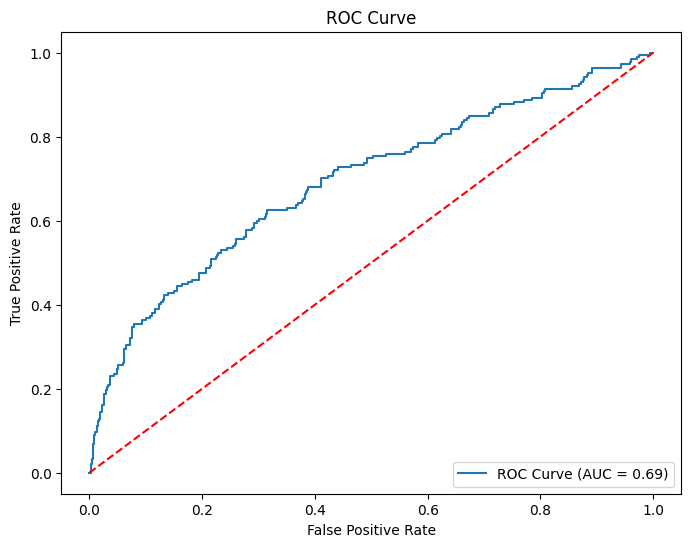

In [124]:
# Separate features and target
X = df.drop(['target', 'event', 'text'], axis=1)  # Dropping non-numerical and non-relevant columns
y = df['target'].map({'false': 1, 'true': 0, 'unverified': 0})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Calculate the scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Train the XGBoost model with class weights
model = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred))
print("XGBoost Accuracy Score:")
print(accuracy_score(y_test, y_pred))

# ROC Curve and AUC
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


**XGBoost achieved an accuracy of approximately 73%, with a good precision for true rumors but a lower recall for false rumors. The model was showing signs of overfitting, which affected its generalization. The AUC is around the same as Random Forest, with a curve that still outperformed Logistic Regression. The model managed to maintain good precision but at the cost of recall, especially for false rumors.**

## RNN

In [125]:
# Define parameters
max_words = 10000
max_sequence_length = 100
embedding_dim = 100

# Tokenization and padding
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text'])
X = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(X, maxlen=max_sequence_length)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['target'])
y = np.eye(len(le.classes_))[y]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# RNN Model
def build_rnn_model(input_shape, output_units):
    model = tf.keras.Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=input_shape),
        SimpleRNN(units=128, return_sequences=False),
        Dense(output_units, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train the model
rnn_model = build_rnn_model(X_train.shape[1], y_train.shape[1])

# Training the model
history = rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Predict on the test set
y_test_pred_probs = rnn_model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_test_true, y_test_pred, target_names=le.classes_)

# Evaluate the model
loss, accuracy = rnn_model.evaluate(X_test, y_test)

# Calculate accuracy scores for each event
event_names = df['event'].unique()
event_accuracies = []

for event in event_names:
    event_indices = df[df['event'] == event].index
    X_event = X[event_indices]
    y_event_true = y[event_indices]
    
    # Predict
    y_event_pred_probs = rnn_model.predict(X_event)
    y_event_pred = np.argmax(y_event_pred_probs, axis=1)
    y_event_true_labels = np.argmax(y_event_true, axis=1)
    
    # Calculate accuracy
    accuracy = np.mean(y_event_pred == y_event_true_labels)
    event_accuracies.append(accuracy)

# Add mean accuracy
event_accuracies.append(np.mean(event_accuracies))

Epoch 1/10
54/54 [==============================] - 2s 28ms/step - loss: 1.0697 - accuracy: 0.4398 - val_loss: 1.0541 - val_accuracy: 0.4611
Epoch 2/10
54/54 [==============================] - 1s 25ms/step - loss: 0.7074 - accuracy: 0.7396 - val_loss: 1.0700 - val_accuracy: 0.4663
Epoch 3/10
54/54 [==============================] - 1s 26ms/step - loss: 0.2500 - accuracy: 0.9589 - val_loss: 1.2973 - val_accuracy: 0.4456
Epoch 4/10
17/17 [==============================] - 0s 5ms/step


In [128]:
rnn_model.summary()

Model: "sequential_223"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_223 (Embedding)   (None, 100, 100)          1000000   
                                                                 
 simple_rnn_223 (SimpleRNN)  (None, 128)               29312     
                                                                 
 dense_223 (Dense)           (None, 3)                 387       
                                                                 
Total params: 1,029,699
Trainable params: 1,029,699
Non-trainable params: 0
_________________________________________________________________


### Mean accuracy and standard deviation

In [109]:
metrics = np.array(event_accuracies)
mean = np.average(event_accuracies)
std = np.std(event_accuracies)
print(mean, std)

0.8722090361765812 0.05549733477368258


In [110]:
print("RNN Classification Report:\n")
print(report)

print(f"RNN Test Accuracy: {accuracy:.4f}")

RNN Classification Report:

              precision    recall  f1-score   support

       false       0.48      0.54      0.51       114
        true       0.60      0.57      0.59       226
  unverified       0.43      0.42      0.42       141

    accuracy                           0.52       481
   macro avg       0.50      0.51      0.51       481
weighted avg       0.52      0.52      0.52       481

RNN Test Accuracy: 0.8851


### Single accuracy scores for every event

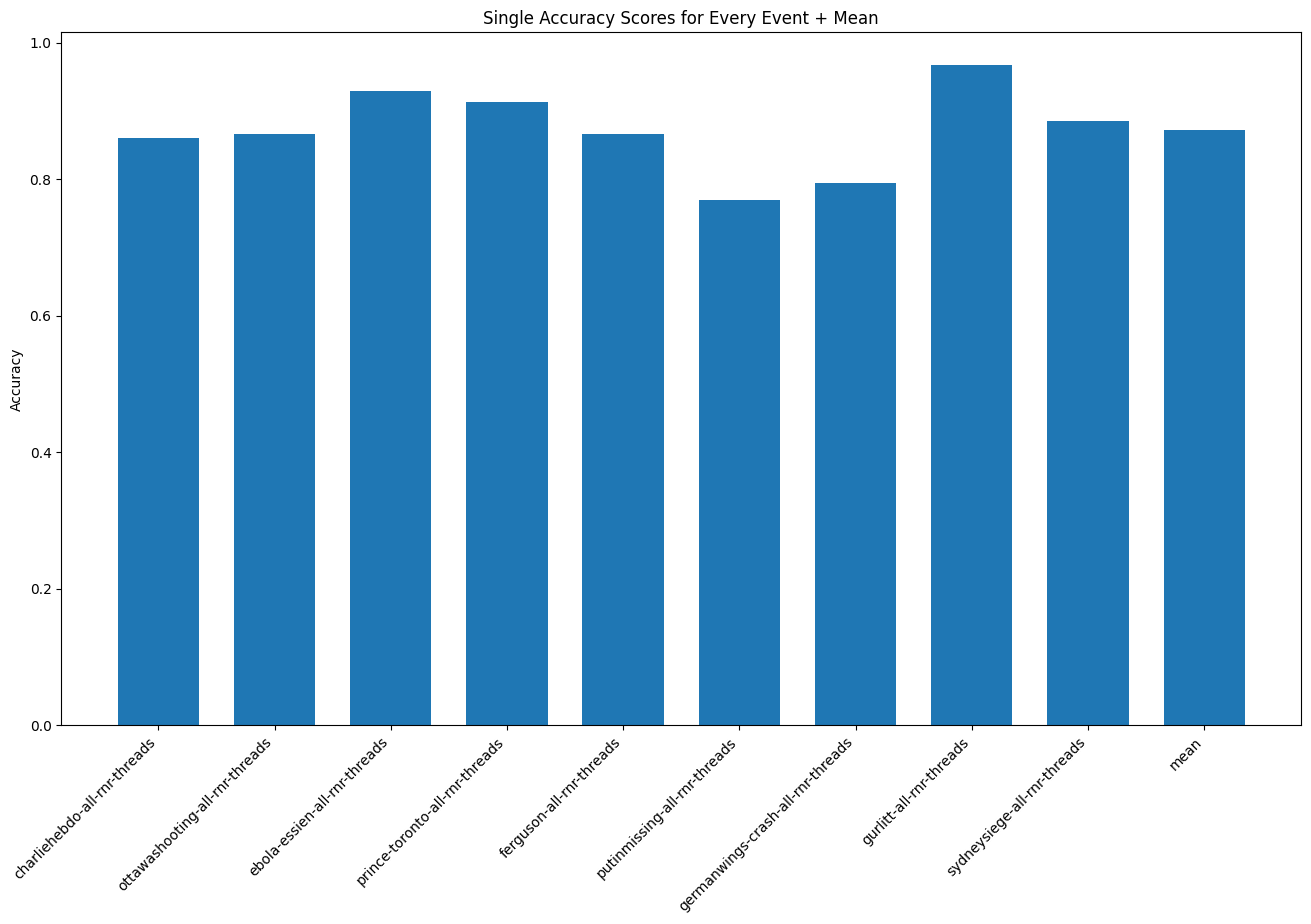

In [111]:
fig = plt.figure(figsize=(16, 9))
column_names = list(event_names) + ['mean']
plt.bar(column_names, event_accuracies, width=0.7)
plt.xticks(rotation=45, ha='right')  # Rotate event names for better readability
plt.ylabel("Accuracy")
plt.title("Single Accuracy Scores for Every Event + Mean")
plt.show()

**The RNN model significantly improved accuracy to around 88.5%, benefiting from its ability to capture sequential patterns in text. The improvement in accuracy is largely due to RNN's strength in modeling temporal dependencies and contextual information in the rumor data, which helped better classify the complex language patterns often present in rumors.**

## LSTM

In [17]:
class attention(Layer):
    # Custom attention layer class definition
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()

    # Initialize the weights and biases for the attention layer
    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        super(attention,self).build(input_shape)
        
     # Calculate attention scores and apply them to the input
    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)

In [18]:
# Define the model using hyperparameters found with Keras Tuner
def build_model(max_len, num_words, embedding_dim, static_input_shape):
   
    # RNN layers
    
    # Input for sequential data
    seq_input = tfkl.Input([max_len], name = "Sequential_Input")
    
    # Embedding layer with pre-trained GloVe embeddings
    emb_layer = Embedding(num_words,
                        embedding_dim,
                        embeddings_initializer=Constant(embedding_matrix),
                        input_length=max_len,
                        trainable=True, name = "Embedding")(seq_input)
    emb_layer = tfkl.SpatialDropout1D(0.2, seed=seed)(emb_layer)
    
    # Bidirectional LSTM layers
    rec_layer1 = tfkl.Bidirectional(LSTM(80, return_sequences= True), name = "Recurrent1")(emb_layer)
    rec_layer2 = tfkl.Bidirectional(LSTM(80, return_sequences= True), name = "Recurrent2")(rec_layer1)
    rec_layer3 = tfkl.Bidirectional(LSTM(140, return_sequences= True), name = "Recurrent3")(rec_layer2)
    rec_layer4 = tfkl.Bidirectional(LSTM(40,return_sequences= True), name = "Recurrent4")(rec_layer3)
    
    # Apply custom attention layer
    attention_layer = attention(return_sequences = False)(rec_layer4)
    drop_layer = tfkl.Dropout(0.2, seed=seed)(attention_layer)    

    # Static Single Layer Percetron
    static_input = tfkl.Input(static_input_shape,name = "Static_Input")
    norm_input = tfkl.BatchNormalization()(static_input)
    static_layer1 = Dense(32,  kernel_regularizer=tfk.regularizers.L2(0.001),  activation='relu',name="Static_dense_1")(norm_input)

    # Concatenate RNN and static features
    combined = tfkl.Concatenate(axis= 1,name = "Concatenated")([drop_layer,static_layer1])
    combined_norm1 = tfkl.BatchNormalization()(combined)
    combined_dense1 = Dense(192, activation='relu',name="Combined_dense1")(combined_norm1)

    # Output layer with softmax activation
    output_layer = Dense(units=3, activation='softmax', kernel_initializer=tfk.initializers.GlorotNormal(seed), name='Output')(combined_dense1)

    # Compile the model
    model = Model(inputs=[seq_input,static_input],outputs=[output_layer], name = "Megazord_Model")
    model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics = ['accuracy'])

    return model

In [19]:
# Early stopping callback to prevent overfitting
callback = EarlyStopping(monitor='val_loss', patience=10)

In [21]:
# Load GloVe vectors into a dictionary
embeddings_index = {}
f = open('../glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [01:16, 28684.56it/s]

Found 2196017 word vectors.


In [22]:
# Plot training and validation accuracy
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

model using as test set:  charliehebdo-all-rnr-threads
size of the test set:  4580


100%|███████████████████████████████████| 3721/3721 [00:00<00:00, 133700.60it/s]


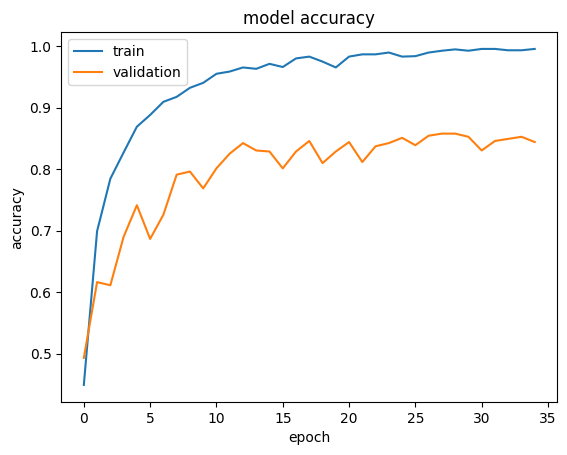

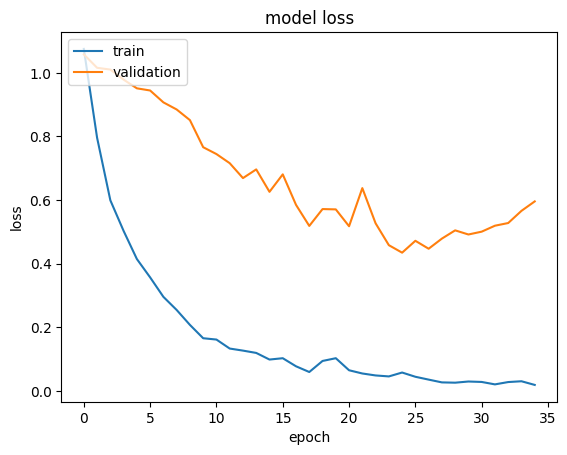

15/15 [==============================] - 961s 891ms/step - loss: 2.7194 - accuracy: 0.3319
model using as test set:  ottawashooting-all-rnr-threads
size of the test set:  4700


100%|████████████████████████████████████| 3721/3721 [00:00<00:00, 17089.90it/s]


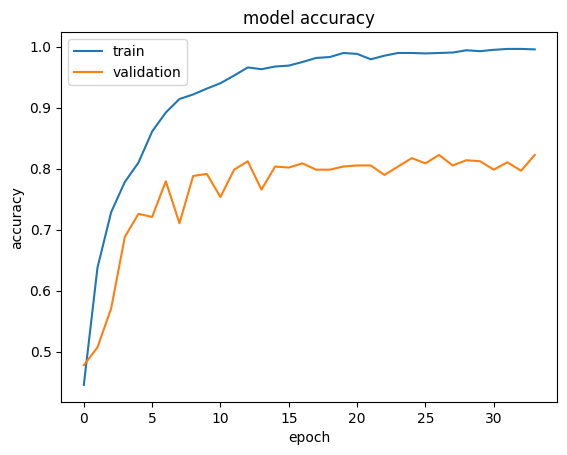

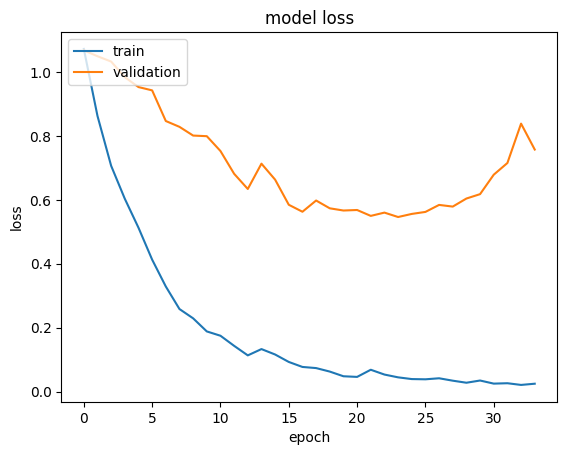

15/15 [==============================] - 20s 1s/step - loss: 2.1627 - accuracy: 0.5170
model using as test set:  ebola-essien-all-rnr-threads
size of the test set:  140


100%|████████████████████████████████████| 3721/3721 [00:00<00:00, 17022.59it/s]


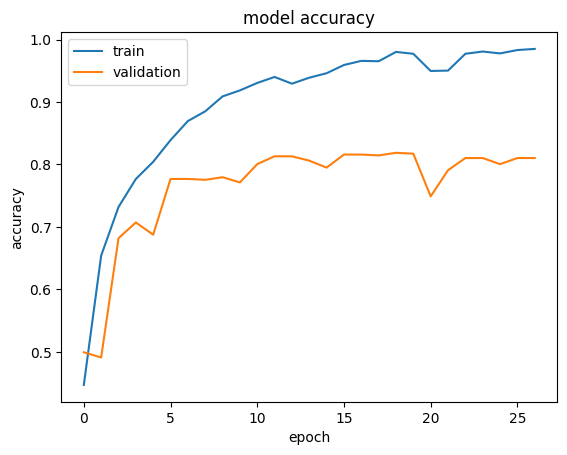

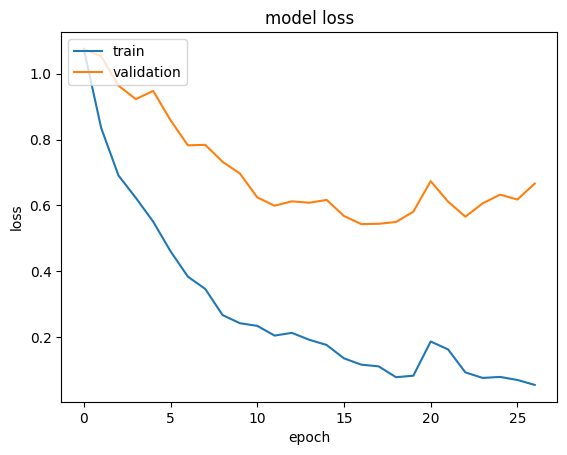

1/1 [==============================] - 1s 627ms/step - loss: 2.9138 - accuracy: 0.0000e+00
model using as test set:  prince-toronto-all-rnr-threads
size of the test set:  2290


100%|████████████████████████████████████| 3721/3721 [00:00<00:00, 17066.76it/s]


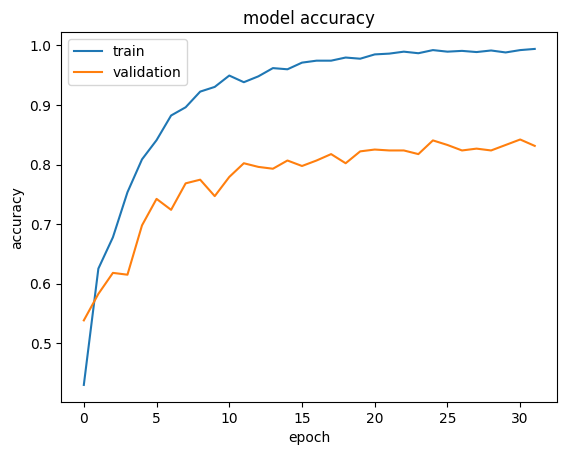

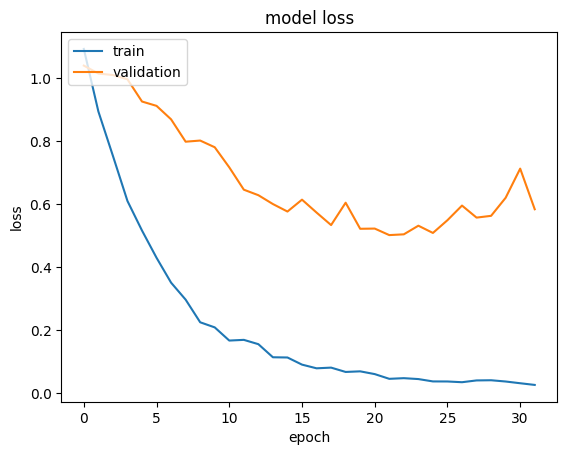

8/8 [==============================] - 10s 1s/step - loss: 4.7869 - accuracy: 0.0524
model using as test set:  ferguson-all-rnr-threads
size of the test set:  2840


100%|████████████████████████████████████| 3721/3721 [00:00<00:00, 17586.23it/s]


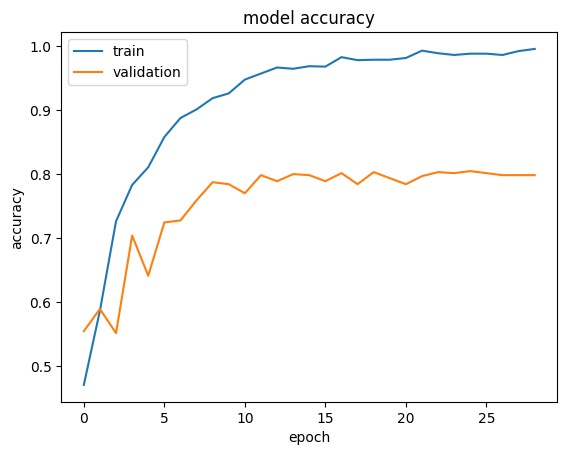

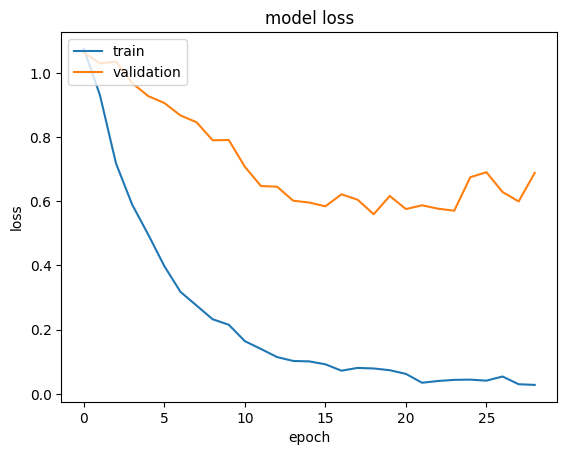

9/9 [==============================] - 11s 1s/step - loss: 2.8947 - accuracy: 0.1585
model using as test set:  putinmissing-all-rnr-threads
size of the test set:  1260


100%|████████████████████████████████████| 3721/3721 [00:00<00:00, 17164.40it/s]


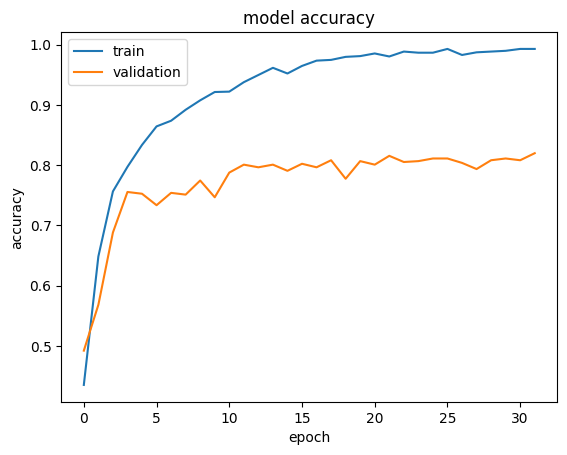

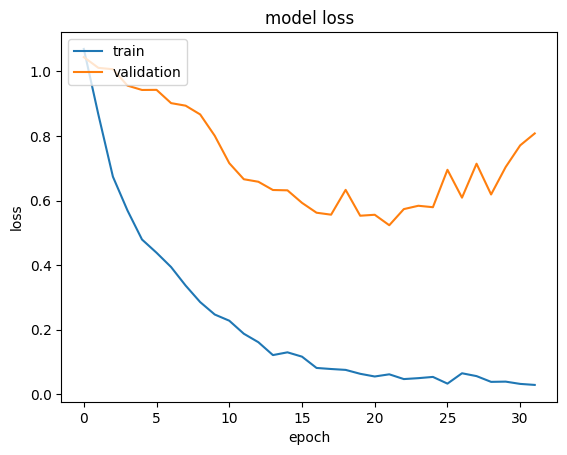

4/4 [==============================] - 5s 1s/step - loss: 3.5237 - accuracy: 0.2063
model using as test set:  germanwings-crash-all-rnr-threads
size of the test set:  2380


100%|████████████████████████████████████| 3721/3721 [00:00<00:00, 16992.41it/s]


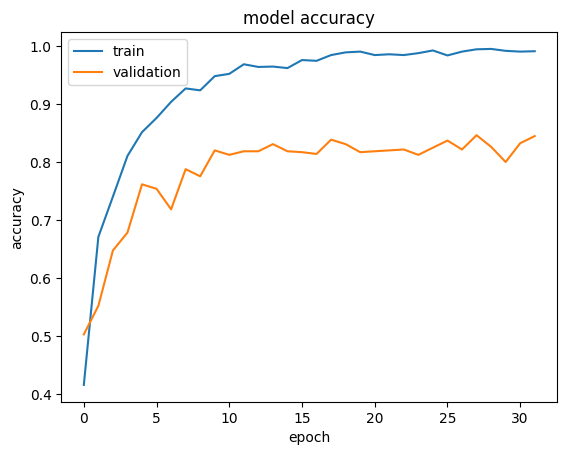

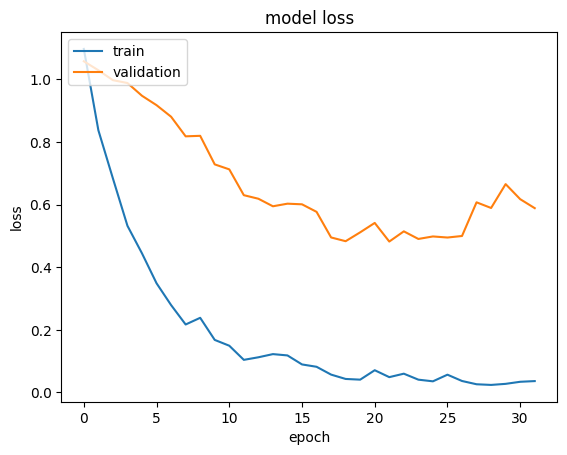

8/8 [==============================] - 9s 1s/step - loss: 2.1722 - accuracy: 0.3908
model using as test set:  gurlitt-all-rnr-threads
size of the test set:  610


100%|████████████████████████████████████| 3721/3721 [00:00<00:00, 17851.49it/s]


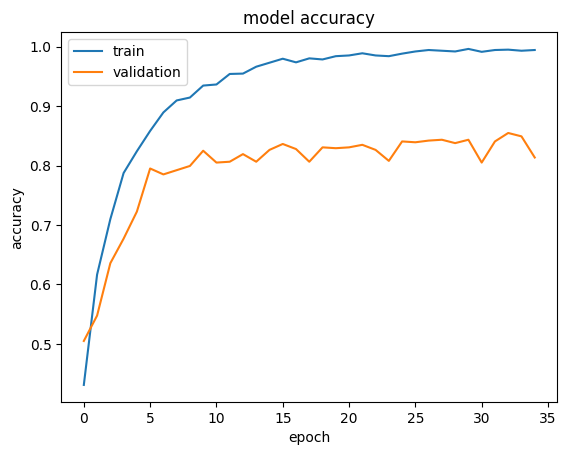

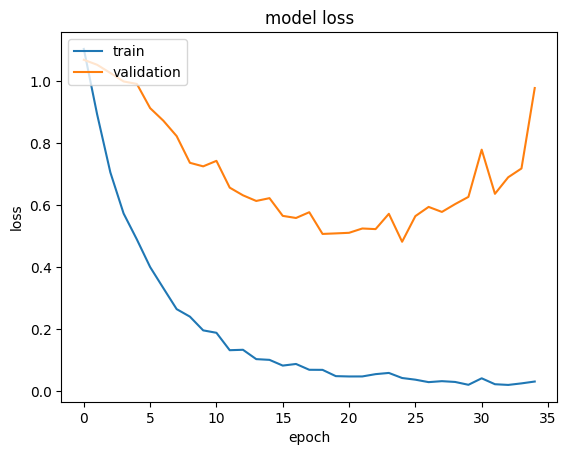

2/2 [==============================] - 4s 2s/step - loss: 8.4171 - accuracy: 0.0656
model using as test set:  sydneysiege-all-rnr-threads
size of the test set:  5220


100%|████████████████████████████████████| 3721/3721 [00:00<00:00, 13808.03it/s]


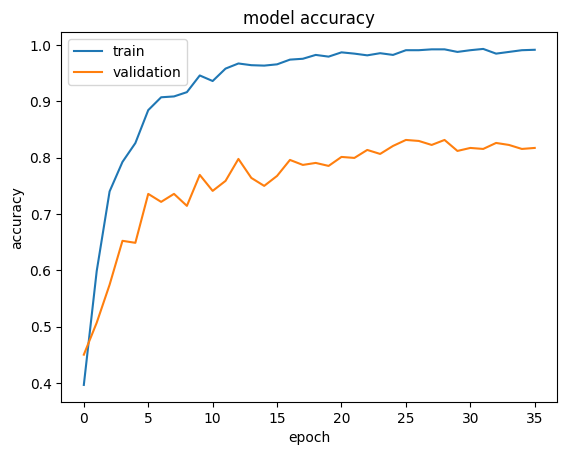

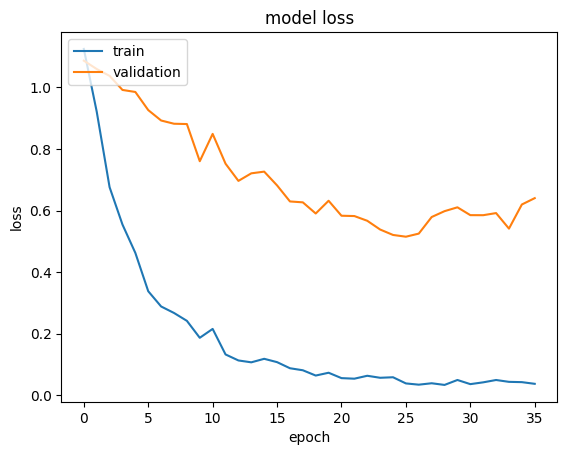

17/17 [==============================] - 18s 1s/step - loss: 2.4663 - accuracy: 0.3563


In [24]:
# Label binarizer for converting categorical target variable into one-hot encoded format
lb = LabelBinarizer()
metrics = []

# Leave-One-Event-Out Cross Validation
for f in folds:
    
    df_train = df[df['event']!=f]
    df_test = df[df['event']==f]
    
    print('model using as test set: ', f)
    print('size of the test set: ',df_test.size)
    
    # Split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(df_train[['text','fav_count','retweet_count','followers','followings','tweet_count','verified','no_hashtags']], df_train['target'], test_size=0.3, random_state=0)
    X_test = df_test[['text','fav_count','retweet_count','followers','followings','tweet_count','verified','no_hashtags']]
    y_test = df_test['target']

    # Separate static features
    X_train_static_ns = X_train[['fav_count','retweet_count','followers','followings','tweet_count','verified','no_hashtags']]
    X_val_static_ns = X_val[['fav_count','retweet_count','followers','followings','tweet_count','verified','no_hashtags']]
    X_test_static_ns = X_test[['fav_count','retweet_count','followers','followings','tweet_count','verified','no_hashtags']]
    
    # Normalize the static features
    scaler = preprocessing.StandardScaler().fit(X_train_static_ns)
    X_train_static = scaler.transform(X_train_static_ns)
    X_val_static = scaler.transform(X_val_static_ns)
    X_test_static = scaler.transform(X_test_static_ns)
    
    # Tokenize and pad the text sequences
    X_train = X_train['text']
    X_val = X_val['text']
    X_test = X_test['text']
    token = Tokenizer(num_words=None) # Using keras tokenizer
    max_len = 1500
    token.fit_on_texts(list(X_train) + list(X_val) + list(X_test))
    xtrain_seq = token.texts_to_sequences(X_train)
    xval_seq = token.texts_to_sequences(X_val)
    xtest_seq = token.texts_to_sequences(X_test)
    xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
    xval_pad = sequence.pad_sequences(xval_seq, maxlen=max_len)
    xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)

    word_index = token.word_index

    y_train = lb.fit_transform(y_train)
    y_val = lb.transform(y_val)
    y_test = lb.transform(y_test)

    # Create embedding matrix
    num_words =  len(word_index) + 1
    embedding_dim = 300
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in tqdm(word_index.items()):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            # Assign random vector if word is not in GloVe embeddings
            embedding_matrix[i] = np.random.randn(embedding_dim)

    static_input_shape = X_train_static.shape[1]
    epochs = 50
    batch_size = 128
    
    # Build and train the model
    model = build_model(max_len, num_words, embedding_dim, static_input_shape)
    history = model.fit([xtrain_pad, X_train_static], y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=0.1, 
                    verbose=0,  # Set to 1 to see the training progress
                    validation_data=([xval_pad, X_val_static], y_val),
                    callbacks=callback)

    # Uncomment to save model
    #model.save('model_{}'.format(f)+'.h5')
    
    # Plot training history
    plot_history(history)
    
    # Evaluate the model and store metrics
    metrics.append(model.evaluate([xtest_pad,X_test_static], y_test))

In [25]:
model.summary()

Model: "Megazord_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequential_Input (InputLayer)  [(None, 1500)]       0           []                               
                                                                                                  
 Embedding (Embedding)          (None, 1500, 300)    1116600     ['Sequential_Input[0][0]']       
                                                                                                  
 spatial_dropout1d_9 (SpatialDr  (None, 1500, 300)   0           ['Embedding[0][0]']              
 opout1D)                                                                                         
                                                                                                  
 Recurrent1 (Bidirectional)     (None, 1500, 160)    243840      ['spatial_dropout1d_

### Mean accuracy and standard deviation

In [26]:
metrics = np.array(metrics)
mean = np.average(metrics[:,1])
std = np.std(metrics[:,1])
print(mean, std)

0.23097251314255926 0.16723482237721773


### Single accuracy scores for every event

In [27]:
scores = metrics[:,1]
scores  = np.append(scores,mean)

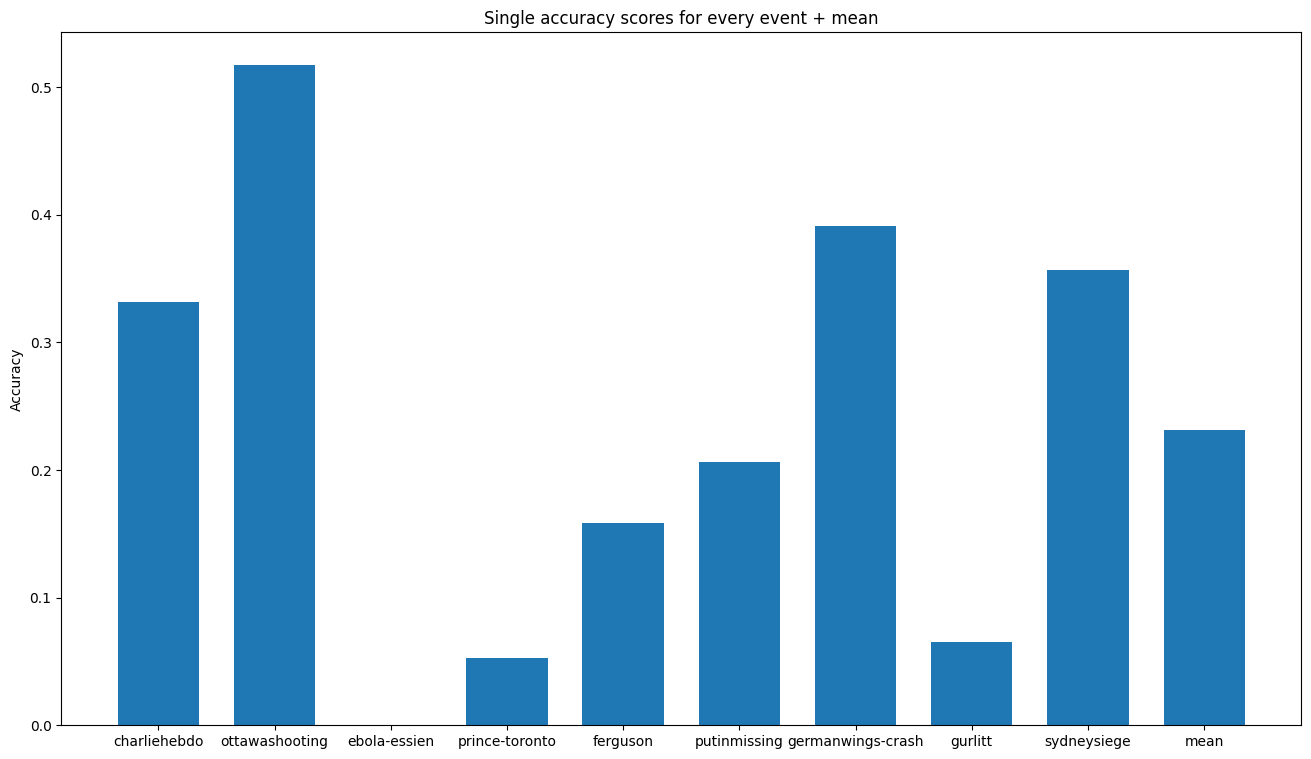

In [28]:
# Single accuracy scores for every event + mean
column_names = ['charliehebdo','ottawashooting',
'ebola-essien','prince-toronto',
'ferguson',	'putinmissing',
'germanwings-crash',
'gurlitt','sydneysiege','mean']

fig = plt.figure(figsize = (16, 9))
plt.bar(column_names, scores, width = 0.7)
plt.ylabel("Accuracy")
plt.title("Single accuracy scores for every event + mean")
plt.show()

**The LSTM model, using leave-one-out cross-validation, showed lower accuracy but offered more reliable results across diverse events. It indicates that each type of tweet in different categories may vary and the model could learn more useful features that generalize better.**